In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import time
import duckdb
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [12]:
# -------- Load ECG5000 Data --------
extract_dir = "ECG5000"  
train_path = os.path.join(extract_dir, "ECG5000_TRAIN.txt")
test_path = os.path.join(extract_dir, "ECG5000_TEST.txt")

df_train = pd.read_csv(train_path, header=None, sep='\s+')
df_test = pd.read_csv(test_path, header=None, sep='\s+')

df = pd.concat([df_train, df_test], ignore_index=True)

In [3]:
# -------- Binary Classification: Label 1 vs 2 --------
df_binary = df[df[0].isin([1, 2])].copy()
df_binary[0] = df_binary[0].map({1: 0, 2: 1})  # Relabel to 0 and 1
df_binary.columns = ['label'] + [f"f{i}" for i in range(df_binary.shape[1] - 1)]

X = df_binary.drop("label", axis=1)
y = df_binary["label"]

In [5]:
# -------- Train Logistic Regression Model --------
model = LogisticRegression(max_iter=1000)
model.fit(X, y)
joblib.dump(model, "ecg5000_binary_model.pkl")

['ecg5000_binary_model.pkl']

In [6]:
# -------- Register to DuckDB --------
con = duckdb.connect()
con.register("ecg_table", df_binary)

In [7]:
# Rewriter Query: simulate pre-filtering features (e.g., f23 > 0.5)
query_df = con.execute("SELECT * FROM ecg_table WHERE f23 > 0.5").df()
query_X = query_df.drop("label", axis=1).values

In [8]:
# -------- Inference Benchmarks --------
model = joblib.load("ecg5000_binary_model.pkl")
columns = [f"f{i}" for i in range(140)]

In [15]:
# Baseline: Load model each time
feature_names = query_df.columns[1:] 
start = time.time()
for _, row in query_df.iterrows():
    input_row = row[1:]
    input_df = pd.DataFrame([input_row.values], columns=feature_names)
    model = joblib.load("ecg5000_binary_model.pkl")
    model.predict(input_df)
end = time.time()
baseline_latency = (end - start) / len(query_df)
print(f" Baseline_latency: {baseline_latency:.6f} s/record")

 Baseline_latency: 0.002203 s/record


In [ ]:
#Rewriter: Load the model once, perform inference record by record
model = joblib.load("ecg5000_binary_model.pkl")
feature_names = query_df.columns[1:]

start = time.time()
for _, row in query_df.iterrows():
    input_row = row[1:]  # drop label
    input_df = pd.DataFrame([input_row.values], columns=feature_names)
    model.predict(input_df)
end = time.time()

rewriter_latency = (end - start) / len(query_df)
print(f"Rewriter latency: {rewriter_latency:.6f} s/record")

Rewriter latency: 0.001478 s/record


In [18]:
#Rewriter + Batch: Load the model once, perform batch inference for all records at once
model = joblib.load("ecg5000_binary_model.pkl")
query_X = query_df.drop("label", axis=1)  

start = time.time()
model.predict(query_X)
end = time.time()

batch_latency = (end - start) / len(query_df)
print(f"Rewriter+Batch latency: {batch_latency:.6f} s/record")

Rewriter+Batch latency: 0.000002 s/record


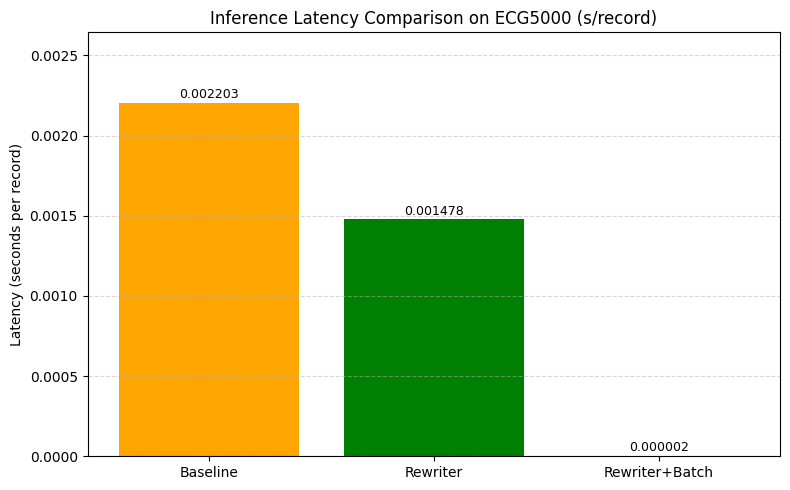

In [19]:
methods = ["Baseline", "Rewriter", "Rewriter+Batch"]
latencies = [baseline_latency, rewriter_latency, batch_latency]

plt.figure(figsize=(8, 5))
bars = plt.bar(methods, latencies, color=["orange", "green", "blue"])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.00001, f"{yval:.6f}", 
             ha="center", va="bottom", fontsize=9)

plt.title("Inference Latency Comparison on ECG5000 (s/record)")
plt.ylabel("Latency (seconds per record)")
plt.ylim(0, max(latencies) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()